### Imports

In [1]:
spark.version

u'2.2.0'

In [2]:
import re
import datetime
from pyspark.sql.functions import *
import pandas as pd
pd.set_option('display.max_colwidth', 80)
pd.set_option('display.max_columns', 40)

### Add Lookup Tables

In [3]:
monthMap = {
    "Jan": "01",
    "Feb": "02",
    "Mar": "03",
    "Apr": "04",
    "May": "05",
    "Jun": "06",
    "Jul": "07",
    "Aug": "08",
    "Sep": "09",
    "Oct": "10",
    "Nov": "11",
    "Dec": "12"
}

teamMap = {
  "Atlanta" : "atl",
  "Boston"  : "bos",
  "Brooklyn"  : "bkn",
  "Charlotte"  : "cha",
  "Chicago"  : "chi",
  "Cleveland"  : "cle",
  "Dallas"  : "dal",
  "Denver"  : "den",
  "Detroit"  : "det",
  "Golden State"  : "gst",
  "Houston"  : "hou",
  "Indiana"  : "ind",
  "LA Clippers"  : "lac",
  "LA Lakers"  : "lal",
  "Memphis"  : "mem",
  "Miami"  : "mia",
  "Milwaukee"  : "mil",
  "Minnesota"  : "min",
  "New Orleans"  : "nor",
  "New York"  : "nyk",
  "Oklahoma City"  : "okc",
  "Orlando"  : "orl",
  "Philadelphia"  : "phi",
  "Phila."  : "phi",
  "Phoenix"  : "pho",
  "Portland"  : "por",
  "Sacramento" : "sac",
  "San Antonio"  : "san",
  "Toronto"  : "tor",
  "Utah"  : "uta",
  "Washington"  : "wsh",
   None : "none"}

### Load In NBA Score Data Set

In [4]:
from pyspark.sql.types import StructType, StructField
from pyspark.sql.types import DoubleType, IntegerType, StringType,DateType

customSchema = StructType([
    StructField("dateOrig", DateType()),
    StructField("ts", StringType()),
    StructField("away_team_full", StringType()),
    StructField("away_score", DoubleType()),
    StructField("home_team_full", StringType()),
    StructField("home_score", DoubleType()),
    StructField("timestring", StringType()),
    StructField("timeleft", DoubleType())
    #StructField("gameid", IntegerType())
])

#nbafile = '/data2/nba-rt-prediction/scoredata/scores_nba.2015.test.dat'
nbafile = '/data2/nba-rt-prediction/scoredata/nrm_scores_nba.2015.test.dat'

rtscoresAndFinalDF = spark.read.format('csv')\
                    .option("header", "false")\
                    .option("inferSchema", "false")\
                    .option("nullValue", "empty")\
                    .option("dateFormat", "yyyy-MM-dd")\
                    .option("mode","DROPMALFORMED")\
                    .schema(customSchema)\
                    .load(nbafile).coalesce(2)
    
rtscoresAndFinalDF.show(5)

# PHO vs ATL -> http://www.espn.com/nba/game?gameId=400829044

+----------+--------+--------------+------------------+--------------+-----------------+--------------+--------+
|  dateOrig|      ts|away_team_full|        away_score|home_team_full|       home_score|    timestring|timeleft|
+----------+--------+--------------+------------------+--------------+-----------------+--------------+--------+
|2016-04-24|12:28:31|       Atlanta|               0.0|        Boston|              0.0|  (6:00 PM ET)|    48.0|
|2016-04-24|18:12:13|       Atlanta|               0.0|        Boston|              3.0|(11:22 IN 1ST)|    47.5|
|2016-04-24|18:13:14|       Atlanta|               0.0|        Boston|              5.0|(10:26 IN 1ST)|    47.0|
|2016-04-24|18:13:14|       Atlanta|1.7647058822491302|        Boston|              5.0|(10:26 IN 1ST)|    46.5|
|2016-04-24|18:14:15|       Atlanta|               2.0|        Boston|5.555555555666675| (9:34 IN 1ST)|    46.0|
+----------+--------+--------------+------------------+--------------+-----------------+--------

### UDFs For Creating Extra Columns In Real Time Data Frame

In [5]:
# Create new team name column.. do simple lookup conversion with a UDF
def mapper(teamin) :
    return teamMap[teamin]

mapperudf = udf(mapper)


In [6]:
# Date Logic to adjust for games that finish on the day after .... 
# This is so that I can join them against the spread which was dated the day prior...
# This is due to not having a great key to join my tables ...

datecrossregex = re.compile("^0[0-3]") # midnight to 3am
def dateadjust(datein, tsin ) : 
    #dateary = datein.split("-")
    tsary   = tsin.split(":")
    sub_one_day = datetime.timedelta(days=1)
    newdate = datein
    if datecrossregex.match(tsary[0]) :
        #day = "%02d".format(int(dateary[2]) -1)
        #newdate = dateary(0) + "-" + dateary(1) + "-" + day   
        newdate = datein - sub_one_day
    return str(newdate)

dateadjustudf = udf(dateadjust)


# UDFs to create some extra features ... this one is for an experiemental combination of Time left and Score difference.  
# Made this via intuition.  This can be extended to add other custom features
#val crossover = 8
#val exp = 0.5
import math
def scoredivtimeXform(score_diff,time_left, crossover, exp):
    rv = score_diff/(math.pow((time_left/crossover) + 0.01, exp))
    return rv

scoredivtimeUdf = udf(scoredivtimeXform)


### Wrangle The Real Time And Final Score Data.  Add Columns To The Data Set

In [7]:
# Remove Overtime games from this analysis
rtscoresAndFinalDF = rtscoresAndFinalDF.filter(~col("timestring").like("%OT%"))

# Create short 3 character team names 
rtscoresAndFinalDF = rtscoresAndFinalDF.withColumn("away_team", mapperudf(col("away_team_full")))
rtscoresAndFinalDF = rtscoresAndFinalDF.withColumn("home_team", mapperudf(col("home_team_full")))

# Add a score differential Column 
rtscoresAndFinalDF = rtscoresAndFinalDF.withColumn("score_diff_amh", col("away_score") - col("home_score"))

# Transform the Date.  This is for games that spanned multiple days and gave me a headache.  
# Games adjusted to the day they started on.
rtscoresAndFinalDF = rtscoresAndFinalDF.withColumn("date",  dateadjustudf(col("dateOrig"),col("ts")))

# Create a Key for me to use to join with my odds data later.  Key = date.away_team_.home_team_
rtscoresAndFinalDF = rtscoresAndFinalDF.withColumn("key", concat(col("date"),lit("."),col("away_team"),lit("."),col("home_team")))

# Create a Key for me to use to join with my odds data later.  Key = date.away_team_.home_team_
rtscoresAndFinalDF = rtscoresAndFinalDF.withColumn("time_elapsed", 48 - col("timeleft"))


In [8]:
rtscoresAndFinalDF.show(5)


+----------+--------+--------------+------------------+--------------+-----------------+--------------+--------+---------+---------+-------------------+----------+------------------+------------+
|  dateOrig|      ts|away_team_full|        away_score|home_team_full|       home_score|    timestring|timeleft|away_team|home_team|     score_diff_amh|      date|               key|time_elapsed|
+----------+--------+--------------+------------------+--------------+-----------------+--------------+--------+---------+---------+-------------------+----------+------------------+------------+
|2016-04-24|12:28:31|       Atlanta|               0.0|        Boston|              0.0|  (6:00 PM ET)|    48.0|      atl|      bos|                0.0|2016-04-24|2016-04-24.atl.bos|         0.0|
|2016-04-24|18:12:13|       Atlanta|               0.0|        Boston|              3.0|(11:22 IN 1ST)|    47.5|      atl|      bos|               -3.0|2016-04-24|2016-04-24.atl.bos|         0.5|
|2016-04-24|18:13:14

### Separate The Real Time And Final Data From One Common Dataframe To Two Dataframes

In [9]:
# Currently based on the way the data was sampled, both real time scores and final scores are written as seperate records to the same file.  I need to pull these apart, and then join the dataframes so that I have a real time score and features, and know if the game was won or lost ....

# Create Final Score DF
# Note a shortcut for repeating the dataframe within the filter is to use a $   df.filter(df("foo").contains ... is equiv to df.filter($"foo".contains)

finalscoresDF = rtscoresAndFinalDF.filter(col("timestring").like("%FINAL%"))

# Rename some columns so that join later doesnt have name overlaps
finalscoresDF = finalscoresDF.withColumnRenamed("away_score", "final_away_score")
finalscoresDF = finalscoresDF.withColumnRenamed("home_score", "final_home_score")

# Create final score difference
finalscoresDF = finalscoresDF.withColumn("score_diff_amh", col("final_away_score") - col("final_home_score"))

# Add a Win/loss column Win = 1, Loss = 0
finalscoresDF = finalscoresDF.withColumn("away_win", (when(col("score_diff_amh") > 0.0, 1.0).otherwise(0)))
finalscoresDF = finalscoresDF.withColumn("home_win", (when(col("score_diff_amh") < 0.0, 1.0).otherwise(0)))

# Create Real time score DF and more wrangling

# Remove Halftime records and these other cases as my datasource doesnt always change the quarter well
# as this particular case isn't handled well... (for now)
#rtscoresDF = rtscoresAndFinalDF.filter(~col("timestring").like("%FINAL%")).filter(~col("timestring").like("HALFTIME"))
rtscoresDF = rtscoresAndFinalDF.filter(~col("timestring").like("%FINAL%")). \
  filter(~col("timestring").like("(HALFTIME)")).  \
  filter(~col("timestring").like("(12:00 IN 1ST)") ). \
  filter(~col("timestring").like("(12:00 IN 2ND)") ). \
  filter(~col("timestring").like("(12:00 IN 3RD)") ). \
  filter(~col("timestring").like("(12:00 IN 4TH)") ). \
  filter(~col("timestring").like("(END OF 1ST)") ). \
  filter(~col("timestring").like("(END OF 2ND)") ). \
  filter(~col("timestring").like("(END OF 3RD)") ). \
  filter(~col("timestring").like("(END OF 4TH)") )


# Create final score difference
rtscoresDF = rtscoresDF.withColumn("score_diff_amh", col("away_score") - col("home_score"))


# Create a game PCT complete and PCT left indictor
rtscoresDF = rtscoresDF.withColumn("pct_complete", (((col("timeleft") * -1) + 48 )/48.0)*100)
rtscoresDF = rtscoresDF.withColumn("pct_left",  lit(100) - col("pct_complete"))



### Add some momentum terms .  
####  in the last 3,6,9 mins what has been the overall trend ..

In [10]:
from pyspark.sql.functions import sum as sum_, lag, col, coalesce, lit, mean
from pyspark.sql.window import Window

#Define window for rolling average - use last 4 mins (8 data points)
w = Window.partitionBy("key").orderBy("pct_complete")

#asm = away score momentum 
rtscoresDF = rtscoresDF.withColumn("amh_3min", lag(col("score_diff_amh"),6,default=0).over(w))
rtscoresDF = rtscoresDF.withColumn("asm_3min", col("score_diff_amh") - col("amh_3min"))

rtscoresDF = rtscoresDF.withColumn("amh_6min", lag(col("score_diff_amh"),12,default=0).over(w))
rtscoresDF = rtscoresDF.withColumn("asm_6min", col("score_diff_amh") - col("amh_6min"))

rtscoresDF = rtscoresDF.withColumn("amh_9min", lag(col("score_diff_amh"),24,default=0).over(w))
rtscoresDF = rtscoresDF.withColumn("asm_9min", col("score_diff_amh") - col("amh_9min"))


rtscoresDF.select(["pct_complete", "score_diff_amh", "asm_3min","asm_6min","asm_9min"]).toPandas()

,pct_complete,score_diff_amh,asm_3min,asm_6min,asm_9min
0,0.000000,0.000000,0.000000,0.000000,0.000000
1,1.041667,-3.000000,-3.000000,-3.000000,-3.000000
2,2.083333,-5.000000,-5.000000,-5.000000,-5.000000
3,3.125000,-3.235294,-3.235294,-3.235294,-3.235294
4,4.166667,-3.555556,-3.555556,-3.555556,-3.555556
5,5.208333,-4.272727,-4.272727,-4.272727,-4.272727
6,6.250000,-3.000000,-3.000000,-3.000000,-3.000000
7,7.291667,-1.000000,2.000000,-1.000000,-1.000000
8,8.333333,-2.000000,3.000000,-2.000000,-2.000000
9,9.375000,-1.000000,2.235294,-1.000000,-1.000000


### Custom Feature Explanation
After building my initial model, I noticed that the logistic model was adjusting the probabilities well at the end of the games.  I had some examples where I had 0 time left in the game, and yet the logistic model was giving a 70% chance of victory for a team.  I speculated this was due to the fact that my original features were not fitting the end of game very well.  To fix this, I created a spreader custom feature that basically takes the score difference and amplifies it as the score nears the end of the game.  This way this feature is very predictive at the end of games and can help adjust the probablities to be more certain at the end of games.

In [11]:
# Create a unique feature based on my custom UDF.  Idea here is that I have intuition that timeleft and score difference are a strong predictor when combined
rtscoresDF = rtscoresDF.withColumn("cf1", scoredivtimeUdf(col("score_diff_amh"), col("pct_left"), lit(25.0), lit(0.5)))
rtscoresDF = rtscoresDF.withColumn("cf2", scoredivtimeUdf(col("score_diff_amh"), col("pct_left"), lit(2.0), lit(1.3)))


### Lets Take A Look Of What We Have For The Two Dataframes We Just Wrangled

In [12]:
# Some Printouts .....
print("final scores data frame")
finalscoresDF.show(5)
print("real time scores data frame")
rtscoresDF.show(5)
finalscoresDF.printSchema


print "##########################################"
print "Total Data Points in rtscoresDF = {0}".format(rtscoresDF.count())
print "Total Data Points in rtscoresDF uniq = {0}".format(rtscoresDF.sort("key").distinct().count())
print "Total Data Points in finalscoresDF = {0}".format(finalscoresDF.count())
print "##########################################"




final scores data frame
+----------+--------+--------------+----------------+--------------+----------------+----------+--------+---------+---------+--------------+----------+------------------+------------+--------+--------+
|  dateOrig|      ts|away_team_full|final_away_score|home_team_full|final_home_score|timestring|timeleft|away_team|home_team|score_diff_amh|      date|               key|time_elapsed|away_win|home_win|
+----------+--------+--------------+----------------+--------------+----------------+----------+--------+---------+---------+--------------+----------+------------------+------------+--------+--------+
|2016-04-23|00:04:09|   San Antonio|            96.0|       Memphis|            87.0|   (FINAL)|     0.0|      san|      mem|           9.0|2016-04-22|2016-04-22.san.mem|        48.0|     1.0|     0.0|
|2016-04-17|17:38:44|       Detroit|           101.0|     Cleveland|           106.0|   (FINAL)|     0.0|      det|      cle|          -5.0|2016-04-17|2016-04-17.det.cl

### Interpret the Odds data
````How to interpret the odds data ...
Example Golden State -12.5 O (207.0) -125.0 | Detroit 12.5 U (207.0) 145.0
Here Golden State the away team is a 12.5 pt favorite to win.  The over under is in parentheses (207) and is the 50/50 line between teams sum of scores
being above/below that line.  
Finally the -125 / +145 numbers are whats known at the moneyline odds. 
    A negative number means you need to bet 125$ to get a 100$ payout
    A positive number means you need to bet 100$ to get a 145$ payout
```

### Load In Odds Data

In [13]:
# Here, the data is very raw, and needs to be pre-processed .  I will start by loading it as an RDD and perform a lot of transformations.  Once I have it properly parsed, I will convert to a dataframe.
# This is not beautiful, but gets the job done
# Data format .....
#       <title>New Orleans 2.5 O (207.0) 125.0 | Phila. -2.5 U (207.0) -145.0 (Apr 05, 2016 07:10 PM)</title>
#       <title>Detroit 4.0 O (202.0) 160.0 | Miami -4.0 U (202.0) -190.0 (Apr 05, 2016 08:05 PM)</title>
oddsfile = "/data2/nba-rt-prediction/nbaodds_042516.xml"

# Reading the data in as an RDD first.  There isn't a dataframe parser for this XML I have, so I will write a custom parser ....
oddsrdd = spark.read.text(oddsfile).rdd
# just grabbing the text within the < ... > tags.  I can do this, because the format is super simple and not nested
# the subscript [0] is due to the fact that spark.read.text read in the oddsfile of Type Row.  Need to index
# into it to get the string
gameStringRdd = oddsrdd.map(lambda x : x[0][x[0].find('>')+1:x[0].rfind('<')])


In [14]:
# This is where I do the heavy lifting of parsing my XML .. and then finally convert my RDD to a dataframe .....
# just lots of string parsing and data type conversions
def parseOdds(line_in) : 
    away_str = line_in[0:line_in.find('|')]  
    home_and_date_str = line_in[line_in.find('|')+2:-1]
    home_str = home_and_date_str[0:home_and_date_str.rfind('(')]
    date_str = home_and_date_str[home_and_date_str.rfind('(')+1:len(home_and_date_str)]
    date_str = date_str.replace(',', '')
    
    # parse away string
    overunder = away_str[away_str.find('(')+1:away_str.find(')')]
    away_team_ml = away_str[away_str.find(')')+2:len(away_str)-1]
    away_str_2 = away_str[0:away_str.find('(')-3]
    away_team_spread = away_str_2[away_str_2.rfind(' ')+1:len(away_str_2)]
    away_team_full = away_str_2[0:away_str_2.rfind(' ')]
    away_team = teamMap[away_team_full]
    
     # parse home string
    overunder = home_str[home_str.find('(')+1:home_str.find(')')]
    home_team_ml = home_str[home_str.find(')')+2:len(home_str)-1]
    home_str_2 = home_str[0:home_str.find('(')-3]
    home_team_spread = home_str_2[home_str_2.rfind(' ')+1:len(home_str_2)]
    home_team_full = home_str_2[0:home_str_2.rfind(' ')]
    home_team = teamMap[home_team_full]
   
    # parse date string
    dateInfo = date_str.split(' ')
    dateStr = dateInfo[2] + "-" + monthMap[dateInfo[0]] + "-" + dateInfo[1]
    # This will become my join key for the other data sets
    key = dateStr +"." + away_team + "." + home_team
    return (key,away_team_full,away_team,away_team_spread,away_team_ml,overunder,home_team_full,home_team,home_team_spread,home_team_ml,dateStr)

#def parseOdds(line_in) : 
#    away_str = line_in[0:line_in.find('|')]  
#    return (away_str,away_str)


oddsDF = gameStringRdd.map(lambda x : parseOdds(x))\
        .toDF(["key","away_team_full","away_team","away_team_spread","away_team_ml","overunder","home_team_full","home_team","home_team_spread","home_team_ml","dateStr"]).distinct()

# OddsDF has some dups due to the fact that I have multiple readings ...
oddsDF.registerTempTable("odds_table")

oddsDF = spark.sql("SELECT key, FIRST(away_team_full) as away_team_full, FIRST(away_team) as away_team,\
  AVG(away_team_spread) as away_team_spread, AVG(overunder) as overunder, AVG(away_team_ml) as away_team_ml,\
  FIRST(home_team_full) as home_team_full,FIRST(home_team) as home_team, AVG(home_team_spread) as home_team_spread, \
  AVG(home_team_ml) as home_team_ml, FIRST(dateStr) as dateStr FROM odds_table GROUP BY key").cache()

oddsDF = oddsDF. \
    withColumn("away_team_vegas_fscore", col("overunder") / 2.0 - col("away_team_spread")/2.0). \
    withColumn("home_team_vegas_fscore", col("overunder") / 2.0 + col("away_team_spread")/2.0)


### Inspect Some Of The Odds Data

In [15]:
oddsDF.show(5)
print "Total Home Teams      = {0}".format(oddsDF.select("home_team").distinct().count())
print "Total Away Teams      = {0}".format(oddsDF.select("away_team").distinct().count())
print "Total Games Collected = {0} ".format(oddsDF.count())


+------------------+--------------+---------+----------------+---------+------------+--------------+---------+----------------+------------+----------+----------------------+----------------------+
|               key|away_team_full|away_team|away_team_spread|overunder|away_team_ml|home_team_full|home_team|home_team_spread|home_team_ml|   dateStr|away_team_vegas_fscore|home_team_vegas_fscore|
+------------------+--------------+---------+----------------+---------+------------+--------------+---------+----------------+------------+----------+----------------------+----------------------+
|2016-04-24.atl.bos|       Atlanta|      atl|             1.5|    203.5|         0.0|        Boston|      bos|            -1.5|      -120.0|2016-04-24|                 101.0|                 102.5|
|2016-04-19.mem.san|       Memphis|      mem|           18.25|    187.0|      -110.0|   San Antonio|      san|          -18.25|      -110.0|2016-04-19|                84.375|               102.625|
|2016-04-2

### Join The Odds And Final Score Data Sets

In [16]:
# Here is where we join the Odds/Realtime scores/ Final Scores into one wholistic data set as input for Logistic Machine Learning

# Create a smaller Final Score Dataframe.  Just keep the key, final score a and b, the win/loss indicator
finalslicedscoresDF1 = finalscoresDF.select(["key","final_away_score","final_home_score","away_win", "home_win"]).distinct()
# First Join the 2 smallest data frames ... odd and final.
gameDF = oddsDF.join(finalslicedscoresDF1, oddsDF["key"] == finalslicedscoresDF1["key"], "inner").drop(oddsDF["key"])
# Drop these redundant columns prior to joining with Realtime score dataframe
gameDF = gameDF.drop("away_team_full")
gameDF = gameDF.drop("home_team_full")
gameDF = gameDF.drop("away_team")
gameDF = gameDF.drop("home_team")

gameDF.show(3)

+----------------+---------+------------+----------------+------------+----------+----------------------+----------------------+------------------+----------------+----------------+--------+--------+
|away_team_spread|overunder|away_team_ml|home_team_spread|home_team_ml|   dateStr|away_team_vegas_fscore|home_team_vegas_fscore|               key|final_away_score|final_home_score|away_win|home_win|
+----------------+---------+------------+----------------+------------+----------+----------------------+----------------------+------------------+----------------+----------------+--------+--------+
|           18.25|    187.0|      -110.0|          -18.25|      -110.0|2016-04-19|                84.375|               102.625|2016-04-19.mem.san|            68.0|            94.0|     0.0|     1.0|
|             5.0|    206.5|       170.0|            -5.0|      -200.0|2016-04-13|                100.75|                105.75|2016-04-13.mia.bos|            88.0|            98.0|     0.0|     1.0|


In [17]:
# Print Out the Game Dataframe ... notice we have the odds data merged with the win loss data ....
#print("gameDF")
#gameDF.sort(["key"]).show(152)
print "Total finalscoresDF = {0}".format(finalscoresDF.count())
print "Total oddsDF = {0}".format(oddsDF.count())
print "Total Games after joining odds and score data = {0}".format(gameDF.count())

#gameDF.select("key").sort(["key"]).show(144)
#finalscoresDF.filter(col("key") == "2016-04-24.gst.hou").show()
#oddsDF.filter(col("key") == "2016-04-24.gst.hou").show()


Total finalscoresDF = 118
Total oddsDF = 111
Total Games after joining odds and score data = 101


### Join The Game Dataframe With The Real Time Score Dataframe

In [18]:
cleanedDF = rtscoresDF.join(gameDF, rtscoresDF["key"] == gameDF["key"], "inner").drop(gameDF["key"])
print("cleanedDF : Cleaned Data Frame for use with ML algos")

print "Total Data Points in rtscoresDF = {0}".format(rtscoresDF.count())
print "Total Data Points in gameDF = {0}".format(gameDF.count())
print "Total Data Points in joined cleanedDF = {0}".format(cleanedDF.count())

cleanedDF.toPandas()

cleanedDF : Cleaned Data Frame for use with ML algos
Total Data Points in rtscoresDF = 14517
Total Data Points in gameDF = 101
Total Data Points in joined cleanedDF = 11370


,dateOrig,ts,away_team_full,away_score,home_team_full,home_score,timestring,timeleft,away_team,home_team,score_diff_amh,date,time_elapsed,pct_complete,pct_left,amh_3min,asm_3min,amh_6min,asm_6min,amh_9min,asm_9min,cf1,cf2,away_team_spread,overunder,away_team_ml,home_team_spread,home_team_ml,dateStr,away_team_vegas_fscore,home_team_vegas_fscore,key,final_away_score,final_home_score,away_win,home_win
0,2016-04-20,00:01:44,Memphis,68.000000,San Antonio,94.000000,(0:00 IN 4TH),0.0,mem,san,-26.000000,2016-04-19,48.0,100.000000,0.000000,-25.706422,-0.293578,-23.375000,-2.625000,-18.000000,-8.000000,-260.0,-10350.78643439093,18.25,187,-110,-18.25,-110,2016-04-19,84.375,102.625,2016-04-19.mem.san,68,94,0,1
1,2016-04-20,00:01:44,Memphis,67.291667,San Antonio,93.020833,(0:00 IN 4TH),0.5,mem,san,-25.729167,2016-04-19,47.5,98.958333,1.041667,-24.916667,-0.812500,-24.104167,-1.625000,-22.479167,-3.250000,-113.19324190710749,-58.6111277804243,18.25,187,-110,-18.25,-110,2016-04-19,84.375,102.625,2016-04-19.mem.san,68,94,0,1
2,2016-04-19,23:59:43,Memphis,66.000000,San Antonio,93.750000,(0:56 IN 4TH),1.0,mem,san,-27.750000,2016-04-19,47.0,97.916667,2.083333,-25.431193,-2.318807,-20.000000,-7.750000,-20.000000,-7.750000,-90.83319681073318,-25.99090763905623,18.25,187,-110,-18.25,-110,2016-04-19,84.375,102.625,2016-04-19.mem.san,68,94,0,1
3,2016-04-20,00:01:44,Memphis,66.583333,San Antonio,92.041667,(0:00 IN 4TH),1.0,mem,san,-25.458333,2016-04-19,47.0,97.916667,2.083333,-24.645833,-0.812500,-23.833333,-1.625000,-22.208333,-3.250000,-83.33195683386941,-23.844511362557185,18.25,187,-110,-18.25,-110,2016-04-19,84.375,102.625,2016-04-19.mem.san,68,94,0,1
4,2016-04-19,23:59:13,Memphis,65.944954,San Antonio,91.926606,(1:28 IN 4TH),1.5,mem,san,-25.981651,2016-04-19,46.5,96.875000,3.125000,-25.155963,-0.825688,-19.812500,-6.169151,-19.736842,-6.244809,-70.71309838493812,-14.424437980062384,18.25,187,-110,-18.25,-110,2016-04-19,84.375,102.625,2016-04-19.mem.san,68,94,0,1
5,2016-04-20,00:01:44,Memphis,65.875000,San Antonio,91.062500,(0:00 IN 4TH),1.5,mem,san,-25.187500,2016-04-19,46.5,96.875000,3.125000,-24.375000,-0.812500,-23.562500,-1.625000,-21.937500,-3.250000,-68.551692107057,-13.98354270723335,18.25,187,-110,-18.25,-110,2016-04-19,84.375,102.625,2016-04-19.mem.san,68,94,0,1
6,2016-04-19,23:59:13,Memphis,65.119266,San Antonio,90.825688,(1:28 IN 4TH),2.0,mem,san,-25.706422,2016-04-19,46.0,95.833333,4.166667,-23.375000,-2.331422,-19.437500,-6.268922,-19.210526,-6.495896,-61.159556234375444,-9.839017370067486,18.25,187,-110,-18.25,-110,2016-04-19,84.375,102.625,2016-04-19.mem.san,68,94,0,1
7,2016-04-20,00:01:44,Memphis,65.166667,San Antonio,90.083333,(0:00 IN 4TH),2.0,mem,san,-24.916667,2016-04-19,46.0,95.833333,4.166667,-24.104167,-0.812500,-23.291667,-1.625000,-21.666667,-3.250000,-59.28060603243134,-9.536742062451225,18.25,187,-110,-18.25,-110,2016-04-19,84.375,102.625,2016-04-19.mem.san,68,94,0,1
8,2016-04-19,23:59:13,Memphis,64.293578,San Antonio,89.724771,(1:28 IN 4TH),2.5,mem,san,-25.431193,2016-04-19,45.5,94.791667,5.208333,-20.000000,-5.431193,-19.062500,-6.368693,-17.250000,-8.181193,-54.42603609681962,-7.2917785972786175,18.25,187,-110,-18.25,-110,2016-04-19,84.375,102.625,2016-04-19.mem.san,68,94,0,1
9,2016-04-20,00:01:44,Memphis,64.458333,San Antonio,89.104167,(0:00 IN 4TH),2.5,mem,san,-24.645833,2016-04-19,45.5,94.791667,5.208333,-23.833333,-0.812500,-23.020833,-1.625000,-21.395833,-3.250000,-52.74526572703724,-7.066595830201531,18.25,187,-110,-18.25,-110,2016-04-19,84.375,102.625,2016-04-19.mem.san,68,94,0,1


///////////////////////////////////////////////
// Add an overunder/spread adjusted projection 
// as points are scored during the game
// I found this is a strong indicator
lrDF = lrDF.withColumn("teama_adj_fscore",(( $"pct-complete" * -1)/100 + 1) *  $"teama_vegas_fscore" + $"scorea")
           .withColumn("teamb_adj_fscore",(( $"pct-complete" * -1)/100 + 1) *  $"teamb_vegas_fscore" + $"scoreb")
           .withColumn("pfscoreb-pfscorea", $"teamb_adj_fscore" - $"teama_adj_fscore" )

### Anomaly Detection for timeseries data
There is an issue with the data I had captured.  When a quarter transitions from 1st->2nd (etc,etc), sometime the timestring doesn't get updated properly.  Since I used the timestring to calculate the timeleft in the game, I would get some rogue data points.  
Example, after 1 min in a game, something the two teams would have scores in the 20's, because it was really at 11 mins in the second quarter.  
My solution was to use the final score sum, and then just scale that down to the time left in the game.  I would then compare to the sum of scores i had, and if it was significantly higher, I would remove them.  I did this by visual inspection ... 
#### dfa = departure_from_avg

In [19]:
cleanedDF.show(1)

+----------+--------+--------------+----------+--------------+----------+-------------+--------+---------+---------+--------------+----------+------------+------------+--------+-------------------+-------------------+-------------------+------------------+--------+--------+------+------------------+----------------+---------+------------+----------------+------------+----------+----------------------+----------------------+------------------+----------------+----------------+--------+--------+
|  dateOrig|      ts|away_team_full|away_score|home_team_full|home_score|   timestring|timeleft|away_team|home_team|score_diff_amh|      date|time_elapsed|pct_complete|pct_left|           amh_3min|           asm_3min|           amh_6min|          asm_6min|amh_9min|asm_9min|   cf1|               cf2|away_team_spread|overunder|away_team_ml|home_team_spread|home_team_ml|   dateStr|away_team_vegas_fscore|home_team_vegas_fscore|               key|final_away_score|final_home_score|away_win|home_win|
+-

In [20]:
# scaled projected score - current score = normalized score

from pyspark.sql.functions import stddev, mean

cleanedDF = cleanedDF.withColumn("dfa", \
          (((col("final_away_score") + col("final_home_score"))/48) * col("time_elapsed")) - \
          (col("away_score") + col("home_score")) \
        )           



In [21]:
dfa_average = cleanedDF.agg(mean(cleanedDF["dfa"]).alias("mean")).collect()[0]["mean"]
dfa_stddev =  cleanedDF.agg(stddev(cleanedDF["dfa"]).alias("stddev")).collect()[0]["stddev"]

print dfa_average  
print dfa_stddev
sigma = 3.0    

# Create a Z-score and then filter by Zscore.  Eg is deviation > 3.0 sigma, flag as outlier
cleanedDF = cleanedDF.withColumn("outlier",  \
    when( abs((col("dfa") - lit(dfa_average)) / lit(dfa_stddev)) > sigma, 1.0). \
    otherwise(0.0)
    )



-1.57543418256
16.6211552115


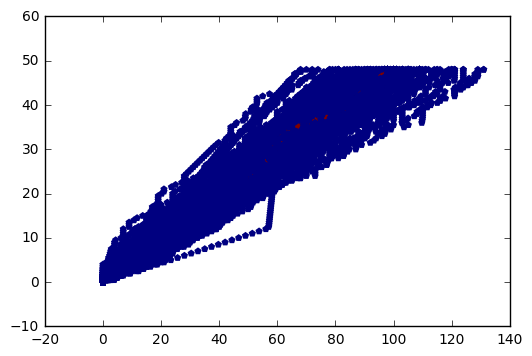

,dateOrig,ts,away_team_full,away_score,home_team_full,home_score,timestring,timeleft,away_team,home_team,score_diff_amh,date,time_elapsed,pct_complete,pct_left,amh_3min,asm_3min,amh_6min,asm_6min,amh_9min,asm_9min,cf1,cf2,away_team_spread,overunder,away_team_ml,home_team_spread,home_team_ml,dateStr,away_team_vegas_fscore,home_team_vegas_fscore,key,final_away_score,final_home_score,away_win,home_win,dfa,outlier
0,2016-04-24,23:16:22,Cleveland,100.000000,Detroit,98.000000,(0:00 IN 4TH),0.0,cle,det,2.000000,2016-04-24,48.0,100.000000,0.000000,5.230769,-3.230769,6.000000,-4.000000,3.000000,-1.000000,20.0,796.2143411069945,-6.25,198,-265,6.25,225,2016-04-24,102.125,95.875,2016-04-24.cle.det,0,0,0,0,-198.000000,1
1,2016-04-24,23:15:52,Cleveland,100.000000,Detroit,98.000000,(0:10 IN 4TH),0.5,cle,det,2.000000,2016-04-24,47.5,98.958333,1.041667,4.744681,-2.744681,5.000000,-3.000000,1.466667,0.533333,8.79882690128123,4.55600669386294,-6.25,198,-265,6.25,225,2016-04-24,102.125,95.875,2016-04-24.cle.det,0,0,0,0,-198.000000,1
2,2016-04-24,23:10:50,Cleveland,99.298701,Detroit,95.298701,(0:42 IN 4TH),1.0,cle,det,4.000000,2016-04-24,47.0,97.916667,2.083333,6.340426,-2.340426,3.000000,1.000000,0.454545,3.545455,13.093073414159518,3.7464371371611946,-6.25,198,-265,6.25,225,2016-04-24,102.125,95.875,2016-04-24.cle.det,0,0,0,0,-194.597403,1
3,2016-04-24,23:10:50,Cleveland,98.129870,Detroit,94.129870,(0:42 IN 4TH),1.5,cle,det,4.000000,2016-04-24,46.5,96.875000,3.125000,7.936170,-3.936170,2.923077,1.076923,2.951220,1.048780,10.886621079036347,2.2207114969303583,-6.25,198,-265,6.25,225,2016-04-24,102.125,95.875,2016-04-24.cle.det,0,0,0,0,-192.259740,1
4,2016-04-24,23:03:18,Cleveland,97.000000,Detroit,93.000000,(1:59 IN 4TH),2.0,cle,det,4.000000,2016-04-24,46.0,95.833333,4.166667,7.846154,-3.846154,1.333333,2.666667,2.219512,1.780488,9.51661902861774,1.530982003336651,-6.25,198,-265,6.25,225,2016-04-24,102.125,95.875,2016-04-24.cle.det,0,0,0,0,-190.000000,1
5,2016-04-24,23:02:48,Cleveland,97.000000,Detroit,92.904762,(2:29 IN 4TH),2.5,cle,det,4.095238,2016-04-24,45.5,94.791667,5.208333,6.000000,-1.904762,2.285714,1.809524,4.036364,0.058874,8.764338321548196,1.1742103444514558,-6.25,198,-265,6.25,225,2016-04-24,102.125,95.875,2016-04-24.cle.det,0,0,0,0,-189.904762,1
6,2016-04-24,23:02:18,Cleveland,96.230769,Detroit,91.000000,(2:50 IN 4TH),3.0,cle,det,5.230769,2016-04-24,45.0,93.750000,6.250000,6.000000,-0.769231,3.000000,2.230769,4.581818,0.648951,10.258382453374958,1.1842864264107258,-6.25,198,-265,6.25,225,2016-04-24,102.125,95.875,2016-04-24.cle.det,0,0,0,0,-187.230769,1
7,2016-04-24,23:01:47,Cleveland,95.000000,Detroit,90.255319,(3:16 IN 4TH),3.5,cle,det,4.744681,2016-04-24,44.5,92.708333,7.291667,5.000000,-0.255319,3.695652,1.049029,5.127273,-0.382592,8.638599560071835,0.8796799637101934,-6.25,198,-265,6.25,225,2016-04-24,102.125,95.875,2016-04-24.cle.det,0,0,0,0,-185.255319,1
8,2016-04-24,23:01:47,Cleveland,95.000000,Detroit,88.659574,(3:16 IN 4TH),4.0,cle,det,6.340426,2016-04-24,44.0,91.666667,8.333333,3.000000,3.340426,5.000000,1.340426,5.672727,0.667698,10.820826188207022,0.9886433397827007,-6.25,198,-265,6.25,225,2016-04-24,102.125,95.875,2016-04-24.cle.det,0,0,0,0,-183.659574,1
9,2016-04-24,23:01:47,Cleveland,95.000000,Detroit,87.063830,(3:16 IN 4TH),4.5,cle,det,7.936170,2016-04-24,43.5,90.625000,9.375000,2.923077,5.013093,8.000000,-0.063830,6.765957,1.170213,12.79029640773182,1.0621458301704751,-6.25,198,-265,6.25,225,2016-04-24,102.125,95.875,2016-04-24.cle.det,0,0,0,0,-182.063830,1


In [22]:
import matplotlib.pyplot as plt
%matplotlib notebook
%matplotlib inline
#plt.hist(dfa.values, log=False)

dfa = cleanedDF.select(["dfa","away_score","time_elapsed", "outlier"]).toPandas()

plt.scatter(dfa["away_score"].values,dfa["time_elapsed"].values, c=dfa.outlier, s=30, marker='p', edgecolors='none')
plt.show()

cleanedDF.filter(col("outlier") == 1).toPandas()

### Save out cleanedDF for followon activities!

In [23]:
 cleanedDF.describe().toPandas()

,summary,ts,away_team_full,away_score,home_team_full,home_score,timestring,timeleft,away_team,home_team,score_diff_amh,date,time_elapsed,pct_complete,pct_left,amh_3min,asm_3min,amh_6min,asm_6min,amh_9min,asm_9min,cf1,cf2,away_team_spread,overunder,away_team_ml,home_team_spread,home_team_ml,dateStr,away_team_vegas_fscore,home_team_vegas_fscore,key,final_away_score,final_home_score,away_win,home_win,dfa,outlier
0,count,11370,11370,11370,11370,11370,11370,11370,11370,11370,11370,11370,11370,11370,11370,11370,11370,11370,11370,11370,11370,11370,11370,11370,11370,11370,11370,11370,11370,11370,11370,11370,11370,11370,11370,11370,11370,11370
1,mean,None,None,47.65672515406304,None,50.81754184878661,None,24.675153913808266,None,None,-3.1608166947235734,None,23.324846086191734,48.59342934623278,51.40657065376722,-2.867890599171499,-0.29292609555207544,-2.5709542995970267,-0.5898623951265466,-2.03664120815457,-1.1241754865690023,-4.180809420364832,-32.86601283611199,3.410055702140135,204.98070214013478,14.290164174728831,-3.410055702140135,-113.05870712401055,None,100.78532321899736,104.19537892113749,None,96.89595426561125,102.63948988566403,0.34160070360598066,0.6413368513632366,-1.5754341825623481,0.01248900615655233
2,stddev,None,None,29.939332539429167,None,31.475648058391982,None,14.021275852467017,None,None,11.173179481567455,None,14.021275852467019,29.21099135930633,29.210991359306288,10.606294234761798,3.4801319787716283,9.989592161997658,4.902228944689721,8.672590006571602,6.82679615303116,27.235690238229374,905.4088518890235,7.900560649057038,9.609784578600243,251.15595033401596,7.900560649057038,251.4768496745076,None,5.764752357228874,6.644624847806678,None,18.02773909055312,17.809853833590854,0.4742672723420565,0.4796291557022703,16.621155211544547,0.11105906390956317
3,min,00:00:03,Atlanta,0.0,Atlanta,0.0,(0:00 IN 1ST),0.0,atl,atl,-43.64285714286631,2016-04-05,0.0,0.0,0.0,-43.64285714286631,-15.63636363643802,-43.64285714286631,-23.288770053507065,-40.94117647065052,-28.984782608514564,-0.005238166915153938,-0.001013412479506225,-13.0,180.5,-553.3333333333334,-19.0,-750.0,2016-04-05,84.375,84.91666666666667,2016-04-05.cha.tor,0.0,0.0,0.0,0.0,-200.0,0.0
4,max,23:59:51,Washington,131.0,Washington,144.0,(9:59 IN 4TH),48.0,wsh,wsh,33.0,2016-04-24,48.0,100.0,100.0,33.0,14.64000000007681,33.0,22.51282051292307,32.72010512484289,30.463414634217727,98.98680263941388,9554.572093283936,19.0,225.25,541.6666666666666,13.0,410.0,2016-04-24,115.75,119.125,2016-04-24.san.mem,131.0,144.0,1.0,1.0,20.958333333333343,1.0


In [24]:
# Since the data is small, you can coalesce to a single partition
# cleanedDF.coalesce(1).write.partitionBy('away_team_').mode('overwrite').format("csv").save("/data2/nba-rt-prediction/sparkfiles/cleanedDF")
cleanedDF.coalesce(1).write.partitionBy('key').mode('overwrite').format("csv").option("header","true").save("/data2/nba-rt-prediction/sparkfiles/cleanedDF")